# <font color='violet'>Modeling</font>

This notebook builds on exploration I did with various encoding, class balancing, and dimension reduction strategies in the preprocessing stage: https://github.com/fractaldatalearning/Capstone2/blob/main/notebooks/7-kl-preprocess-encoding.ipynb

Previously, I tuned encoders and selected the Target Encoder with default hyperparameters. Here, I'll use a random grid search to find the best classifier and its best parameters. I'm using random search not only because it's faster, but also because I've read that its results as effective as a regular grid search if it's iterated over multiple times. Also, if I use a random grid search, it will be fast enough to enable me to work with more chunks of the dataset and compare results across subsets. 

In [1]:
import pandas as pd
import numpy as np
import os
from library.sb_utils import save_file

import matplotlib.pyplot as plt
import seaborn as sns

import category_encoders as ce

import sklearn
from sklearn import svm, neighbors, ensemble, model_selection, preprocessing, metrics
from sklearn.pipeline import Pipeline

from statistics import mean

import warnings
import random

from IPython.display import Audio
sound_file = './alert.wav'

In [2]:
df = pd.read_csv('../data/processed/for_modeling.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2170652 entries, 0 to 2170651
Data columns (total 26 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   user_id                       int64  
 1   order_by_user_sequence        int64  
 2   order_dow                     int64  
 3   order_hour_of_day             int64  
 4   days_since_prior_order        float64
 5   add_to_cart_sequence          int64  
 6   reordered                     int64  
 7   product_name                  object 
 8   aisle_name                    object 
 9   dept_name                     object 
 10  prior_purchases               int64  
 11  purchased_percent_prior       float64
 12  apple                         int64  
 13  bar                           int64  
 14  cream                         int64  
 15  free                          int64  
 16  fresh                         int64  
 17  green                         int64  
 18  mix                   

<font color='violet'>Encode categorical columns based on encoder selected during preprocessing. Normalize ordinal columns.</font>

Previously when I was previewing the performance of encoders, I had used StandardScaler afterward to normalize numerical columns. I have since learned that using MinMaxScaler is a better choice if I don't know that my columns are normally distributed. I actually learned during EDA that variables are in fact not normally distributed, so MinMaxScaler is a better option. 

My current understanding is that since Target Encoder returns values between 0 and 1, MinMaxScaler won't mess up those values. But if I'm wrong, then I'll need to make sure to only use MinMaxScaler on the ordinal columns. 

In [3]:
categorical_columns = ['user_id', 'product_name', 'aisle_name', 'dept_name']

X = df.drop(columns=['reordered', 'add_to_cart_sequence'])
y = df['reordered']
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3)

target = ce.target_encoder.TargetEncoder(cols=categorical_columns)
target.fit(X_train, y_train)
X_train = target.transform(X_train)
X_test = target.transform(X_test)

X_train.head(2)

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/category_encoders/target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/category_encoders/target_encoder.py:127: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."


,user_id,order_by_user_sequence,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_name,dept_name,prior_purchases,purchased_percent_prior,...,fresh,green,mix,natural,organic,original,sweet,white,purchased_early_past,percent_past_purchased_early
1769067,0.055934,44,1,8,6.0,4.813896e-01,0.206787,0.124756,1,0.022727,...,0,0,0,0,1,0,0,0,1,0.022727
2022646,0.116788,5,2,9,8.0,1.701543e-13,0.011011,0.032038,1,0.200000,...,0,0,0,0,0,0,0,0,1,0.200000


In [4]:
# Encoding worked. Scale/normalize. 
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled[0]

array([0.05845517, 0.43434343, 0.16666667, 0.34782609, 0.22580645,
       0.48153644, 1.        , 0.9855581 , 0.01282051, 0.0232438 ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 1.        , 0.        ,
       0.        , 0.        , 0.01388889, 0.02348485])

In [5]:
# After some trial and error, for the purposes of the grid search, I'll need to use 0.1% of users
# Even random grid search is too slow otherwise. 
all_users = set(df['user_id'].unique())
users_search = random.sample(list(all_users), 203)
df_search = df.loc[df['user_id'].isin(users_search), :].copy()

X_search = df_search.drop(columns=['reordered', 'add_to_cart_sequence'])
y_search = df_search['reordered']
X_s_train, X_s_test, y_s_train, y_s_test = model_selection.train_test_split(
    X_search, y_search, test_size=0.3)

target = ce.target_encoder.TargetEncoder(cols=categorical_columns)
target.fit(X_s_train, y_s_train)
X_s_train = target.transform(X_s_train)
X_s_test = target.transform(X_s_test)

scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_s_train_scaled = scaler.transform(X_s_train)
X_s_test_scaled = scaler.transform(X_s_test)

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/category_encoders/target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/category_encoders/target_encoder.py:127: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."


Values for categorical columns match those that were created with the Target Encoder, so it's fine to move forward. 

<font color='violet'>Use random grid search to select a model</font>

A faster way (which is what I need) to tune models than regular GridSearch is a randomized grid search. I learned that repeating the random grid search 3-5 times results in finding the best option comparably as well as searching over all combinations. 

In [6]:
# Initialize classifiers and dictionary of parameter options for each 

clf1 = neighbors.KNeighborsClassifier()
param1 = dict(clf=(clf1,), clf__n_neighbors=list(np.arange(3,22,2)), 
              clf__weights=['uniform','distance'],
              clf__leaf_size=list(np.arange(10,101,10)), 
              clf__p=[1,2], clf__metric=['euclidean','chebyshev','minkowski'])

clf2 = svm.SVC(random_state=43)
param2 = dict(clf=(clf2,), clf__C=list(np.arange(1,11)), 
              clf__kernel=['linear', 'poly', 'rbf', 'sigmoid'],
              clf__degree=list(np.arange(1,11)), clf__gamma=['scale', 'auto'], 
              clf__coef0=list(np.arange(0,4,0.5)), clf__shrinking=[True,False], 
              clf__probability=[True,False], clf__class_weight=[None,'balanced'])

clf3 = ensemble.RandomForestClassifier(random_state=43)
param3 = dict(clf=(clf3,), clf__n_estimators=list(np.arange(100,201,10)), 
              clf__criterion=['gini', 'entropy'], 
              clf__max_depth=list(np.arange(2,21)), 
              clf__min_samples_split=[2,3,4,5], clf__min_samples_leaf=[1,2,3,4,5], 
              clf__min_weight_fraction_leaf=[0,0.1,0.2,0.3,0.4,0.5], 
              clf__max_features=['sqrt', 'log2', None], 
              clf__oob_score=[True,False],
              clf__class_weight=['balanced', 'balanced_subsample'], 
              clf__ccp_alpha=list(np.arange(0,1.1,0.1)))

clf4 = ensemble.BaggingClassifier(random_state=43)
param4 = dict(clf=(clf4,), clf__n_estimators=list(np.arange(2,21,2)), 
              clf__max_samples=list(np.arange(1,11)), 
              clf__max_features=list(np.arange(1,11)), 
              clf__oob_score=[True,False])

clf5 = ensemble.GradientBoostingClassifier(random_state=43)
param5 = dict(clf=(clf5,), clf__loss=['deviance', 'exponential'], 
              clf__learning_rate=list(np.arange(0.1,3.1,0.2)), 
              clf__n_estimators=list(np.arange(100,201,10)), 
              clf__criterion=['friedman_mse', 'squared_error'], 
              clf__min_samples_split=list(np.arange(2,11)), 
              clf__min_samples_leaf=list(np.arange(1,11)),
              clf__min_weight_fraction_leaf=list(np.arange(0,0.6,0.1)), 
              clf__max_depth=list(np.arange(2,11)), 
              clf__min_impurity_decrease=list(np.arange(0,3.1,0.2)), 
              clf__max_features=['auto', 'sqrt', 'log2'])

clf6 = ensemble.AdaBoostClassifier()
param6 = dict(clf=(clf6,), clf__n_estimators=list(np.arange(10,101,10)), 
              clf__learning_rate=list(np.arange(0.1,3.1,0.2)), 
              clf__algorithm=['SAMME', 'SAMME.R'])

# Create pipeline and list of all parameters

pipeline = Pipeline([('clf', clf1)])
params = [param1, param2, param3, param4, param5, param6]

# Find the best classifier & its best parameters:
rs = model_selection.RandomizedSearchCV(estimator=pipeline, param_distributions=params, 
                                        scoring='neg_log_loss',error_score='raise')
rs.fit(X_s_train_scaled, y_s_train)
print(rs.best_params_)
print(rs.best_score_)

{'clf__n_estimators': 150, 'clf__min_weight_fraction_leaf': 0.30000000000000004, 'clf__min_samples_split': 7, 'clf__min_samples_leaf': 9, 'clf__min_impurity_decrease': 0.8, 'clf__max_features': 'sqrt', 'clf__max_depth': 2, 'clf__loss': 'deviance', 'clf__learning_rate': 0.5000000000000001, 'clf__criterion': 'friedman_mse', 'clf': GradientBoostingClassifier(learning_rate=0.5000000000000001, max_depth=2,
                           max_features='sqrt', min_impurity_decrease=0.8,
                           min_samples_leaf=9, min_samples_split=7,
                           min_weight_fraction_leaf=0.30000000000000004,
                           n_estimators=150, random_state=43)}
-0.21780647465001665


In all of the first 5 runs, GradientBoosting came out ahead. 

<font color='violet'>Tune hyperparameters of top classifier: GradientBoosting</font>

In [7]:
gb = ensemble.GradientBoostingClassifier(random_state=43)

params = dict(gb__loss=['deviance', 'exponential'], 
              gb__learning_rate=list(np.arange(0.1,3.1,0.2)), 
              gb__n_estimators=list(np.arange(100,201,10)), 
              gb__criterion=['friedman_mse', 'squared_error'], 
              gb__min_samples_split=list(np.arange(2,11)), 
              gb__min_samples_leaf=list(np.arange(1,11)),
              gb__min_weight_fraction_leaf=list(np.arange(0,0.6,0.1)), 
              gb__max_depth=list(np.arange(2,11)), 
              gb__min_impurity_decrease=list(np.arange(0,3.1,0.2)), 
              gb__max_features=['auto', 'sqrt', 'log2'])

pipeline = Pipeline([('gb', gb)])

rs = model_selection.RandomizedSearchCV(estimator=pipeline, param_distributions=params, 
                                        scoring='neg_log_loss', error_score='raise')
rs.fit(X_s_train_scaled, y_s_train)
print(rs.best_params_)
print(rs.best_score_)

{'gb__n_estimators': 190, 'gb__min_weight_fraction_leaf': 0.1, 'gb__min_samples_split': 10, 'gb__min_samples_leaf': 5, 'gb__min_impurity_decrease': 1.4000000000000001, 'gb__max_features': 'log2', 'gb__max_depth': 6, 'gb__loss': 'deviance', 'gb__learning_rate': 0.30000000000000004, 'gb__criterion': 'friedman_mse'}
-0.21126263275688198


After running the above cell 5 times again, the best results came from the hyperparameters listed in the classifier below. (Outputs above don't match because cells were re-run to clean up the notebook, but scores shown above don't beat the neg_log_loss of -0.20 from the best hyperparameters.)

<font color='violet'>Final Modeling</font>
 
Now that I've selected the GradientBoosting model and its best hyperparameters, I can use the model to make predictions of reorders and get a final evaluation of my model.   

Final log_loss score:  3.033199755613495
Final roc_auc score:  0.5525925821402414
Final f1 score:  0.18960435324793107
AxesSubplot(0.125,0.11;0.62x0.77)


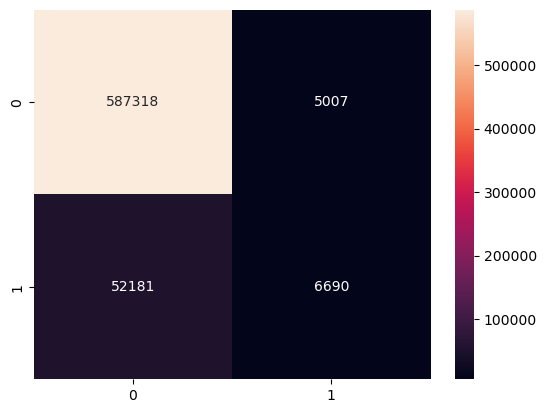

In [8]:
gb = ensemble.GradientBoostingClassifier(random_state=43, max_features='auto', 
                                         min_impurity_decrease=0.3, min_samples_leaf=6, 
                                         min_samples_split=4, min_weight_fraction_leaf=0.1, 
                                         n_estimators=150, max_depth=5, loss='exponential', 
                                         learning_rate=0.3)

gb.fit(X_train_scaled, y_train)
y_pred = gb.predict(X_test_scaled)

print('Gradient Boosting log_loss score: ', metrics.log_loss(y_test, y_pred))
print('Gradient Boosting roc_auc score: ', metrics.roc_auc_score(y_test, y_pred))
print('Gradient Boosting f1 score: ', metrics.f1_score(y_test, y_pred))

GradientBoosting may have overfit during cross-validation, because it's performing much less well on the test data here than the RandomForestClassifier did previously when I was tuning encoders. 

<font color='violet'>Try Hyperparameter Tuning with Random Forest Classifier</font>


In [9]:
rf = ensemble.RandomForestClassifier(random_state=43)
params = dict(rf__n_estimators=list(np.arange(100,201,10)), 
              rf__criterion=['gini', 'entropy'], 
              rf__max_depth=list(np.arange(2,21)), 
              rf__min_samples_split=[2,3,4,5], 
              rf__min_samples_leaf=[1,2,3,4,5], 
              rf__min_weight_fraction_leaf=[0,0.1,0.2,0.3,0.4,0.5], 
              rf__max_features=['sqrt', 'log2', None], 
              rf__oob_score=[True,False],
              rf__class_weight=['balanced', 'balanced_subsample'], 
              rf__ccp_alpha=list(np.arange(0,1.1,0.1)))

pipeline = Pipeline([('rf', rf)])

rs = model_selection.RandomizedSearchCV(estimator=pipeline, param_distributions=params, 
                                        scoring='neg_log_loss', error_score='raise')
rs.fit(X_s_train_scaled, y_s_train)
print(rs.best_params_)
print(rs.best_score_)

{'rf__oob_score': False, 'rf__n_estimators': 120, 'rf__min_weight_fraction_leaf': 0.1, 'rf__min_samples_split': 3, 'rf__min_samples_leaf': 3, 'rf__max_features': None, 'rf__max_depth': 14, 'rf__criterion': 'entropy', 'rf__class_weight': 'balanced_subsample', 'rf__ccp_alpha': 0.2}
-0.5776369529242149


After running the above cell 5 times, the best hyperparameters were those below.

<font color='violet'>Modeling with Random Forest Classifier</font>

Random Forest log_loss score:  3.033199755613495
Random Forest roc_auc score:  0.5525925821402414
Random Forest f1 score:  0.18960435324793107
AxesSubplot(0.125,0.11;0.62x0.77)


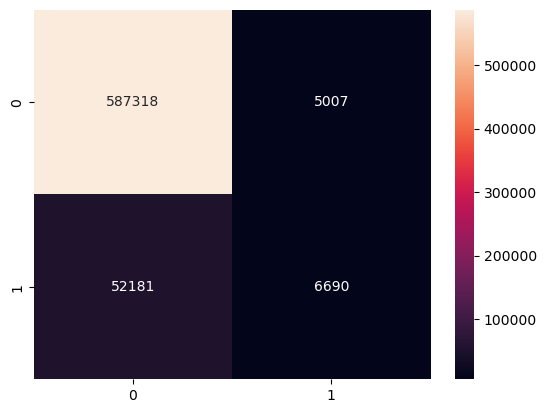

In [10]:
rf = ensemble.RandomForestClassifier(random_state=43, n_estimators=200, criterion='gini', 
                                    max_depth=18, min_samples_split=5, min_samples_leaf=3, 
                                    min_weight_fraction_leaf=0.3, max_features='log2',
                                    class_weight='balanced', ccp_alpha=0.1)
                            
rf.fit(X_train_scaled, y_train)
y_pred = gb.predict(X_test_scaled)

print('Random Forest log_loss score: ', metrics.log_loss(y_test, y_pred))
print('Random Forest roc_auc score: ', metrics.roc_auc_score(y_test, y_pred))
print('Random Forest f1 score: ', metrics.f1_score(y_test, y_pred))

The Random Forest classifier does perform slightly better, with a lower log loss but is otherwise comparable to the Gradient Boosting classifier. 

I am not entirely sure why the roc_auc score here is so low compared with the scores from when I was playing around with encoders previously. One guess is that, because I was then working with just 0.1% of users, those users (despite being randomly chosen) were easy to make predictions for compared with some less consistent shoppers who appear elsewhere in this set of 1% of users. If this is the case, it would require making predictions for all users' reorders in order to know how well the model truly performs more generally. 

Another possible explanation is that this problem, unlike most, actually works better for predicting when there is less data. If this is the case, perhaps it is because user behavior is highly individual and idiosyncratic, such that modeling with multiple users in one dataset leads to users muddying one another's purchasing patterns. I'm not clear whether this is a realistic hypothesis, but I can test it by applying the models iteratively over single users to see if their purchases are predicted better when modeled individually. 

A final consideration before re-modeling: it would be more realistic if each test set is each user's most recent/final order. Split up the data in this fashion. In fact, re-run models with all users but with an improved train/test split, for better comparison of outcomes. 

<font color='violet'>Re-Run Model with Test Set of Only Final Orders</font>

In [17]:
# Get new training and test sets
correct_train = df.loc[df['order_by_user_sequence']!=df['order_by_user_sequence'].max(),:].copy()
correct_test = df.loc[df['order_by_user_sequence']==df['order_by_user_sequence'].max(),:].copy() 

X_c_train = correct_train.drop(columns=['reordered', 'add_to_cart_sequence'])
y_c_train = correct_train['reordered']
X_c_test = correct_test.drop(columns=['reordered', 'add_to_cart_sequence'])
y_c_test = correct_test['reordered']

# Encode and initiate scaler and models
target = ce.target_encoder.TargetEncoder(cols=categorical_columns)
target.fit(X_c_train, y_c_train)
X_c_train = target.transform(X_c_train)
X_c_test = target.transform(X_c_test)

mms = preprocessing.MinMaxScaler()
    
gb = ensemble.GradientBoostingClassifier(random_state=43, max_features='auto', 
                                         min_impurity_decrease=0.3, min_samples_leaf=6, 
                                         min_samples_split=4, min_weight_fraction_leaf=0.1, 
                                         n_estimators=150, max_depth=5, loss='exponential', 
                                         learning_rate=0.3)

rf = ensemble.RandomForestClassifier(random_state=43, n_estimators=200, criterion='gini', 
                                     max_depth=18, min_samples_split=5, min_samples_leaf=3, 
                                     min_weight_fraction_leaf=0.3, max_features='log2',
                                     class_weight='balanced', ccp_alpha=0.1)

# Create pipelines and fit models to training data
gb_pipe = Pipeline([('mms', mms), ('gb', gb)])
rf_pipe = Pipeline([('mms', mms), ('rf', rf)])
    
gb_pipe.fit(X_c_train, y_c_train)
gb_pred = gb_pipe.predict(X_c_test)

rf_pipe.fit(X_c_train, y_c_train)
rf_pred = rf_pipe.predict(X_c_test)


# Score each model again
print('GB correct log_loss score: ', metrics.log_loss(y_c_test, gb_pred))
print('GB correct roc_auc score: ', metrics.roc_auc_score(y_c_test, gb_pred))
print('GB correct f1 score: ', metrics.f1_score(y_c_test, gb_pred))

print('RF correct log_loss score: ', metrics.log_loss(y_c_test, rf_pred))
print('RF correct roc_auc score: ', metrics.roc_auc_score(y_c_test, rf_pred))
print('RF correct f1 score: ', metrics.f1_score(y_c_test, rf_pred))

GB correct log_loss score:  1.8129387332404607
GB correct roc_auc score:  0.5119224281750896
GB correct f1 score:  0.04878048780487805
RF correct log_loss score:  2.556743859529132
RF correct roc_auc score:  0.7154194279815288
RF correct f1 score:  0.40217391304347827


This actually grossly improved outcomes, specifically for the random forest classifier overall and, if focusing exclusively on log loss, for the gradient boosting classifier as well. For the sake of curiosity, carry forward with modeling each user individually. 

<font color='violet'>Apply Model Iteratively</font>

average log_loss:  4.374246734646219
average roc_auce:  0.5937961823558361
average f1 score:  0.23516884043601388
AxesSubplot(0.125,0.11;0.62x0.77)


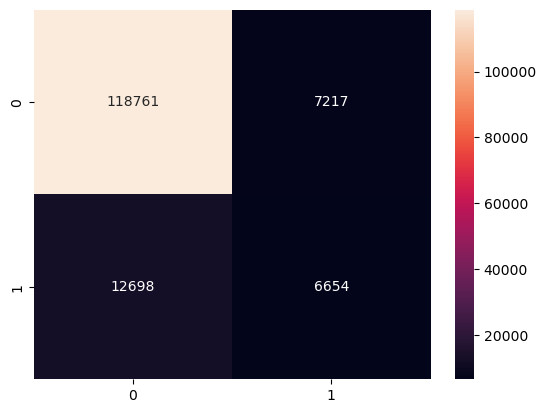

In [13]:
users = list(df['user_id'].unique())
categorical_columns = ['user_id', 'product_name', 'aisle_name', 'dept_name']
log_loss_scores = []
roc_auc_scores = []
f1_scores = []
successful_users = 0

for user in users:
    this_user = df.loc[df['user_id']==user,:].copy()
    
    this_train = this_user.loc[this_user['order_by_user_sequence']!=this_user[
    'order_by_user_sequence'].max(),:].copy()
    
    this_test = this_user.loc[this_user['order_by_user_sequence']==this_user[
        'order_by_user_sequence'].max(),:].copy()    
    
    X_this_train = this_train.drop(columns=['reordered', 'add_to_cart_sequence'])
    y_this_train = this_train['reordered']
    X_this_test = this_test.drop(columns=['reordered', 'add_to_cart_sequence'])
    y_this_test = this_test['reordered']
    
    target = ce.target_encoder.TargetEncoder(cols=categorical_columns)
    target.fit(X_this_train, y_this_train)
    X_this_train = target.transform(X_this_train)
    X_this_test = target.transform(X_this_test)
    
    mms = preprocessing.MinMaxScaler()
    
    gb = ensemble.GradientBoostingClassifier(random_state=43, max_features='auto', 
                                             min_impurity_decrease=0.3, min_samples_leaf=6, 
                                             min_samples_split=4, min_weight_fraction_leaf=0.1, 
                                             n_estimators=150, max_depth=5, loss='exponential', 
                                             learning_rate=0.3)
    
    pipeline = Pipeline([('mms', mms), ('gb', gb)])
    
    # GradientBoosting doesn't work if y_train is all 0s. This could happen for users
    # with few orders and no reorders at all or at least until their last order. 
    try:
        pipeline.fit(X_this_train, y_this_train)
        y_this_pred = pipeline.predict(X_this_test)
        
        log_loss_scores.append(metrics.log_loss(y_this_test, y_this_pred, labels=[0,1]))
        f1_scores.append(metrics.f1_score(y_this_test, y_this_pred, zero_division=0))
        # If a user had no reorders in their final order, roc_auc is impossible. 
        # Since for all I know this user's predictions are as good as random, give these auc=0.5
        try: 
            roc_auc_scores.append(metrics.roc_auc_score(y_this_test, y_this_pred))
        except: roc_auc_scores.append(0.5)
        successful_users += 1
    except: pass
    
print('gb average log_loss: ', mean(log_loss_scores))
print('gb average roc_auce: ', mean(roc_auc_scores))
print('gb average f1 score: ', mean(f1_scores))

In [16]:
# How many users were included in the evaluation above? 
print(successful_users, len(users))

2007 2060


Here, the log loss score is actually much worse than when modeling with the full dataset, but the area under the curve is considerably better and the f1 score is much better. 

Try iterating over users with the random forest model. 

average log_loss:  7.378430363386553
average roc_auce:  0.6761306554494081
average f1 score:  0.3266430634117519
AxesSubplot(0.125,0.11;0.62x0.77)


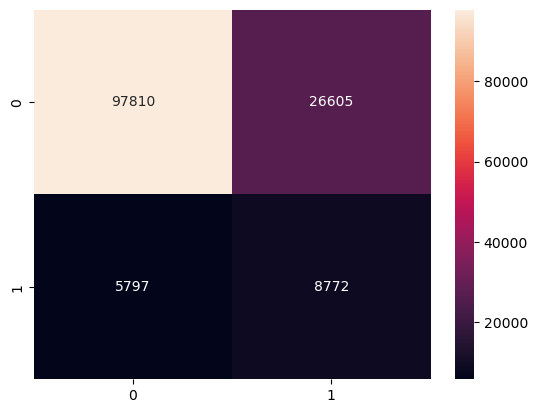

In [12]:
warnings.simplefilter(action='ignore', category=FutureWarning)

users = list(df['user_id'].unique())
categorical_columns = ['user_id', 'product_name', 'aisle_name', 'dept_name']
log_loss_scores = []
roc_auc_scores = []
f1_scores = []

for user in users:
    this_user = df.loc[df['user_id']==user,:].copy()
    
    this_train = this_user.loc[this_user['order_by_user_sequence']!=this_user[
    'order_by_user_sequence'].max(),:].copy()
    
    this_test = this_user.loc[this_user['order_by_user_sequence']==this_user[
        'order_by_user_sequence'].max(),:].copy()    
    
    X_this_train = this_train.drop(columns=['reordered', 'add_to_cart_sequence'])
    y_this_train = this_train['reordered']
    X_this_test = this_test.drop(columns=['reordered', 'add_to_cart_sequence'])
    y_this_test = this_test['reordered']
    
    target = ce.target_encoder.TargetEncoder(cols=categorical_columns)
    target.fit(X_this_train, y_this_train)
    X_this_train = target.transform(X_this_train)
    X_this_test = target.transform(X_this_test)
    
    mms = preprocessing.MinMaxScaler()
    
    rf = ensemble.RandomForestClassifier(random_state=43, n_estimators=200, criterion='gini', 
                                         max_depth=18, min_samples_split=5, min_samples_leaf=3, 
                                         min_weight_fraction_leaf=0.3, max_features='log2',
                                         class_weight='balanced', ccp_alpha=0.1)
    
    pipeline = Pipeline([('mms', mms), ('rf', rf)])
    
    pipeline.fit(X_this_train, y_this_train)
    y_this_pred = pipeline.predict(X_this_test)
    
    log_loss_scores.append(metrics.log_loss(y_this_test, y_this_pred, labels=[0,1]))
    f1_scores.append(metrics.f1_score(y_this_test, y_this_pred, zero_division=0))
    
    # If a user had no reorders in their final order, roc_auc is impossible. 
    # Since for all I know this user's predictions are as good as random, give these auc=0.5
    try: 
        roc_auc_scores.append(metrics.roc_auc_score(y_this_test, y_this_pred))
    except: roc_auc_scores.append(0.5)
    
print('rf average log_loss: ', mean(log_loss_scores))
print('rf average roc_auce: ', mean(roc_auc_scores))
print('rf average f1 score: ', mean(f1_scores))

Directly above, the iterated random forest area under the curve and f1 scores are even better than iterated gradient boosting, but the log loss is even worse. 

The random forest model, used on all data properly split into logical training and test sets, seems to perform best so far. Re-run a grid search given the improved train/test split to see if any different hyperparameters emerge as being best. 

In [ ]:
# Create train and test sets on a small enough portion of the data to grid search

all_users = set(df['user_id'].unique())
users_search = random.sample(list(all_users), 203)
df_search = df.loc[df['user_id'].isin(users_search), :].copy()

correct_search_train = df_search.loc[df_search['order_by_user_sequence']!=df_search[
    'order_by_user_sequence'].max(),:].copy()
    
correct_search_test = df_search.loc[df_search['order_by_user_sequence']==df_search[
        'order_by_user_sequence'].max(),:].copy()    
    
X_cs_train = correct_search_train.drop(columns=['reordered', 'add_to_cart_sequence'])
y_cs_train = correct_search_train['reordered']
X_cs_test = correct_search_test.drop(columns=['reordered', 'add_to_cart_sequence'])
y_cs_test = correct_search_test['reordered']

# Encode, initiate scaler and possible model parameters
target = ce.target_encoder.TargetEncoder(cols=categorical_columns)
target.fit(X_cs_train, y_cs_train)
X_cs_train = target.transform(X_cs_train)
X_cs_test = target.transform(X_cs_test)

mms = preprocessing.MinMaxScaler()

rf = ensemble.RandomForestClassifier(random_state=43)
params = dict(rf__n_estimators=list(np.arange(100,201,10)), 
              rf__criterion=['gini', 'entropy'], 
              rf__max_depth=list(np.arange(2,21)), 
              rf__min_samples_split=[2,3,4,5], 
              rf__min_samples_leaf=[1,2,3,4,5], 
              rf__min_weight_fraction_leaf=[0,0.1,0.2,0.3,0.4,0.5], 
              rf__max_features=['sqrt', 'log2', None], 
              rf__oob_score=[True,False],
              rf__class_weight=['balanced', 'balanced_subsample'], 
              rf__ccp_alpha=list(np.arange(0,1.1,0.1)))

# Create pipeline and conduct random grid ssearch. Print results. 
pipeline = Pipeline([('mms', mms), ('rf', rf)])

rs = model_selection.RandomizedSearchCV(estimator=pipeline, param_distributions=params, 
                                        scoring='neg_log_loss', error_score='raise')
rs.fit(X_cs_train, y_cs_train)
print(rs.best_params_)
print(rs.best_score_)

{'rf__oob_score': False, 'rf__n_estimators': 160, 'rf__min_weight_fraction_leaf': 0.4, 'rf__min_samples_split': 2, 'rf__min_samples_leaf': 5, 'rf__max_features': None, 'rf__max_depth': 16, 'rf__criterion': 'entropy', 'rf__class_weight': 'balanced_subsample', 'rf__ccp_alpha': 0.0}
-0.551604393877853

<font color='violet'>Run Model with Final Hyperparameters; Final Evaluation</font>

In [23]:
# Variables to use in the modeling were already created above
# For encoded train/test data properly split, use X_c_train, X_c_test, y_c_train, y_c_test

# Intialize model with updated best hyperparameters
rf = ensemble.RandomForestClassifier(random_state=43, n_estimators=200, criterion='gini', 
                                     max_depth=18, min_samples_split=5, min_samples_leaf=3, 
                                     min_weight_fraction_leaf=0.3, max_features='log2',
                                     class_weight='balanced', ccp_alpha=0.1)

# Create pipelines and fit models to training data
final_pipe = Pipeline([('mms', mms), ('rf', rf)])
    
final_pipe.fit(X_c_train, y_c_train)
final_pred = rf_pipe.predict(X_c_test)

# Print final scores
print('Final log_loss score: ', metrics.log_loss(y_c_test, final_pred))
print('Final roc_auc score: ', metrics.roc_auc_score(y_c_test, final_pred))
print('Final f1 score: ', metrics.f1_score(y_c_test, final_pred))

Final log_loss score:  2.556743859529132
Final roc_auc score:  0.7154194279815288
Final f1 score:  0.40217391304347827


In [ ]:
# Print a heatmap to visualize the final results
cm = metrics.confusion_matrix(y_c_test, final_pred)
ax = sns.heatmap(data=cm/np.sum(cm), annot=True, center=0.7, cmap='binary').set(title='Confusion Matrix', 
                                                     xlabel='predicted label', 
                                                     ylabel='true label')

In [ ]:
Audio(sound_file, autoplay=True)

<font color='violet'>Summary & Next Steps</font>

My recommendation would be to use this final Random Forest classifer on all data, properly split with the test set consisting of each user's most recent/final order. Although the log loss score is slightly higher than that of the gradient boosting classifier, it's still higher than that of any other models I've tried, and the area under the curve and f1 scores are much better with the random forest classifier. 

All work in my project has been done with only up to 1% of the users I originally had access to. The model could be applied to predict more users' reorders, but first all their data would need to be munged with the steps I've taken throughout this project: 
1. Add rows to every order to indicated non-orders.
2. Add columns for the count and percentage of past orders where somebody has ordered an item and, specifically, ordered it within the first 6 items placed in their cart. 
3. Add columns to indicate the presence of keywords that appear in products' names, i.e. 'organic.'
4. Remove rows for items in the 'missing' department, pending improved re-classification of those items into more intuitive, logical department categories. 
5. Finally, apply a pipeline to encode categorical columns with Target Encoder, normalize ordinal columns with Min Max Scaler, and classify reorders and non-reorders with a Random Forest Classifier. 

Looking forward, I could also try using the add_to_cart_sequence as a dependent variable. See how well I predict not exactly whether an item will be reordered or not, but instead: If I predict the first 5 items to be reordered (placed in the cart early this time), will any one of them end up actually getting reordered? 

Also, the final model as it is with the iterative approach provides no way to give anything other than a random suggestion to any user who has not yet made any reorders. These users might, however, be able to actually get recommendations that are better than random, albeit worse than recommendations for users with a reorder history. This could be done via a dual model method wherein users with no reorders yet are shown recommendations predicted with the random forest model above with all users' orders to date taken as training data. This way, any inherent reorder-ability that exists within particular products, for example, could impact the non-reordering users' recommendations. This could prompt them to make their first reorder of an item that is popularly reordered by many users. They still might not reorder it very often, but this would beat random recommendations. 